# Lecture 16:  Intro to compressed sensing

## Syllabus
**Week 1:** Matrices, vectors, matrix/vector norms, scalar products & unitary matrices  
**Week 2:** TAs-week (Strassen, FFT, a bit of SVD)  
**Week 3:** Matrix ranks, singular value decomposition, linear systems, eigenvalues  
**Week 4:** Matrix decompositions: QR, LU, SVD + test + structured matrices start  
**Week 5:** Iterative methods, preconditioners, matrix functions  
**Week 6:** Advanced topics

## Recap of the previous lecture
- Matrix functions (matrix sign function, matrix square root, some application of the matrix exponential, Rational Krylov methods)
- Maxvol and optimal design

## Today lecture

- Compressed sensing, L1-norm minimization, matching pursuits

## Basic problem setting 

In many applications, we have to deal with **insufficient information,**  i.e. the number of equations is less than the number of parameters.  

For example:

- **Denoising problem:** you are given a "noisy" image $y = x + \eta,$ and you do not know both $x$ and $\eta$, you only know that $\eta$ is "noise".
- **Deblurring / deconvolution:** $y  = Ax + \eta$, the matrix $A$ is ill-conditioned (i.e. close to low-rank matrix), thus there are few effective equations
- **Superresolution:** you are given a low-resolution representation of an image, $y = B x$, where $B$ is rectangular "sampling" operator.

- Inverse problem in general (recover the material coefficients from the measurements)

You have to assume some **prior** information on your solution $x$, since there are many **admissable** solutions.

## Standard case: Tikhonov regularization

The most widely used **regularization** is the so-called Tikhonov regularization (or minimum-norm solution).

Given an underdetermined linear system 

$$Ax = y,$$ where  $A$ is $n \times m$ and $n < m$, 

there are many solutions; the **minimial norm** solution is defined as the one having minimal $2$-norm:

$$x^* = \arg \min_{\mbox{s.t.} Ax = y} \Vert x \Vert_2,$$

and explicit solution is given by the **pseudoinverse:**

$$x^* = A^{\dagger} y.$$

## Other norms

However, the solution will be "smoothed" with this, destroying the original features. 

Many of the signals are "sparse", in the sense they have many zeros. 

This motivates the definition of the "zero-norm" (which is not actually a norm):

$$\Vert x \Vert_0 = \# \{k: x_k \ne 0 \}.$$

(the number of non-zero elements). 

## L1-norm

Minimization of zero-norm is a combinatorial task.

A **convex relaxation** is the 1-norm. That gives the following optimization problem:

$$x^* = \arg \min_{\mbox{s.t.} Ax = y} \Vert x \Vert_1,$$

Which is a **linear programming task.**

Let us see, what will be the solutions for a synthetic problem.

/Users/ivan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:106: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ivan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:110: DeprecationWarning: numpy boolean subtract (the binary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


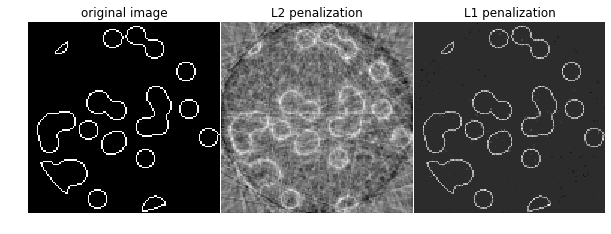

In [68]:
%matplotlib inline
# %load plot_tomography_l1_reconstruction.py
"""
======================================================================
Compressive sensing: tomography reconstruction with L1 prior (Lasso)
======================================================================

This example shows the reconstruction of an image from a set of parallel
projections, acquired along different angles. Such a dataset is acquired in
**computed tomography** (CT).

Without any prior information on the sample, the number of projections
required to reconstruct the image is of the order of the linear size
``l`` of the image (in pixels). For simplicity we consider here a sparse
image, where only pixels on the boundary of objects have a non-zero
value. Such data could correspond for example to a cellular material.
Note however that most images are sparse in a different basis, such as
the Haar wavelets. Only ``l/7`` projections are acquired, therefore it is
necessary to use prior information available on the sample (its
sparsity): this is an example of **compressive sensing**.

The tomography projection operation is a linear transformation. In
addition to the data-fidelity term corresponding to a linear regression,
we penalize the L1 norm of the image to account for its sparsity. The
resulting optimization problem is called the :ref:`lasso`. We use the
class :class:`sklearn.linear_model.Lasso`, that uses the coordinate descent
algorithm. Importantly, this implementation is more computationally efficient
on a sparse matrix, than the projection operator used here.

The reconstruction with L1 penalization gives a result with zero error
(all pixels are successfully labeled with 0 or 1), even if noise was
added to the projections. In comparison, an L2 penalization
(:class:`sklearn.linear_model.Ridge`) produces a large number of labeling
errors for the pixels. Important artifacts are observed on the
reconstructed image, contrary to the L1 penalization. Note in particular
the circular artifact separating the pixels in the corners, that have
contributed to fewer projections than the central disk.
"""

# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    l_x = float(l_x)
    X, Y = np.mgrid[:l_x, :l_x]
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36.
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2) ** 2 + (y - l / 2) ** 2 < (l / 2) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return res - ndimage.binary_erosion(res)


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l / 7.)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

## Laplacian Tortoise and Gaussian Hare

L1-norm can be also used in overdetermined systems:

Instead of minimizing $\Vert Ax - b \Vert_2$, we minimize $\Vert Ax - b \Vert_1$.

In statistics, it has been known for many years, that minimizing the sum of absolute values of residual is better with respect to 

outliers, than the least squares estimator.

But solving **linear least squares** is typically so much faster!

Now, however, methods for linear programming has advanced a lot.

For further info, read the paper [Laplacian Tortoise and Gaussian Hare](https://projecteuclid.org/download/pdf_1/euclid.ss/1030037960)

## Are the signals really sparse?

Let us take an image,

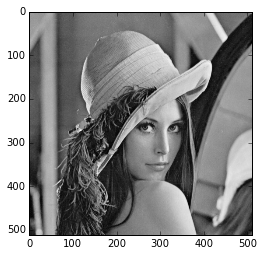

In [69]:
import matplotlib.pyplot as plt
import scipy.misc
lena = scipy.misc.lena()

plt.gray()
plt.imshow(lena)
plt.show()

Is it sparse?

Of course, it is not sparse.

But it is sparse in the **wavelet basis.**

## Idea of discrete wavelet transform

Wavelets are a very important concept. Before, you have heard about Fast Fourier Transform, which is an expansion of the function in the Fourier basis:

$$f(x) \approx \sum_{k} c_k e^{ikx}, $$

and sometimes the coefficients are sparse.

However, trigonometric functions have **global support,** and thus a small change in only place changes coefficients everywhere.

If there is a singularity at some point, all the coefficients start to decay slowly.

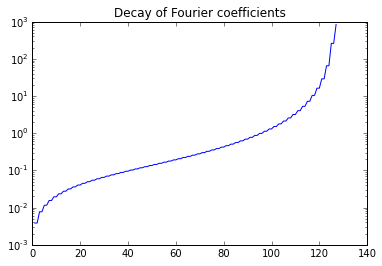

In [72]:
import numpy as np
n = 128
x = np.linspace(-np.pi, np.pi, n)
f1 = (x - np.pi) * (x + np.pi) #np.sqrt(np.abs(np.sin(np.pi*x)))
plt.semilogy(np.sort(abs(np.fft.fft(f1))))
plt.title('Decay of Fourier coefficients')

## How to avoid global basis functions

A useful idea (used, from example, in JPEG), is to use **window FFT**. You select a certain window, and do the transform only there.  

But in this case you consider only one scale of the transformation.

Wavelets bring this idea to the **multilevel** case, and give rise to the **multiresolution analysis.**

## The simplest discrete wavelet transform

The simplest discrete wavelet transform (DWT) is the **Haar wavelet transform.**

It is defined as follows. 

Given a vector of length $2^d$, we compute

$$x'_{2i} = \frac{1}{2} (x_{2i+1} + x_{2i}), \quad x'_{2i+1} = \frac{1}{2}(x_{2i} - x_{2i+1}),$$

i.e. we compute sums and differences of the neighbouring points. 

This is also a **window Fourier transform** with two points.

The idea of wavelets is that we do not stop here: we take the sums, put them into the top $\frac{n}{2}$ elements of the vector, 

and apply the Haar transform once more.

Why it works?

## Why it works

If the vector is constant, after such transform we will get only one non-zero, i.e. compression.

If it is **smooth**, than the differences will be much smaller, than the sums, so we can approximate the result by a sparse vector.

## Discrete wavelet transforms give wavelet bases

DWT gives **wavelet bases**, in the standard form those bases are spanned by the **scaling and translation** of one mother function,

$$\psi_{j, k} = 2^{j/2} \psi(2^j x - k),$$

(for the FFT we only have translation).

Design of the **mother function** $\psi$ gives rise to many other wavelets, and probably the most well-known basis functions are 

wavelets from the **Daubechies** family (used in JPEG2000). 



['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


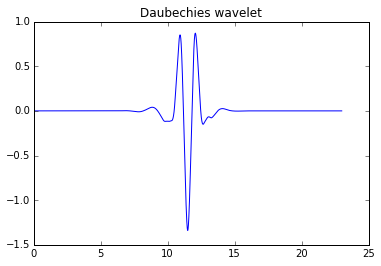

In [82]:
import pywt #python wavelet package
import matplotlib.pyplot as plt
print pywt.wavelist() #List of wavelets
w = pywt.Wavelet('coif4')
phi, psi, x = w.wavefun(level=10)

fig, ax = plt.subplots()
#ax.set_xlim(-.02,1.02)
ax.plot(x, psi);
ax.set_title('Daubechies wavelet')


## Wavelet summary 

- The wavelet basis functions act locally, and the coefficients are **pseudo-sparse** (in the sense, many of them are small). 
- The more sparsity you want, the more local coefficients you need
- Some properties (like orthogonality, smoothness) are difficult to get

For more details, FastPDE course!

## Sparsity of Lena

Let us test the sparsity of Lena

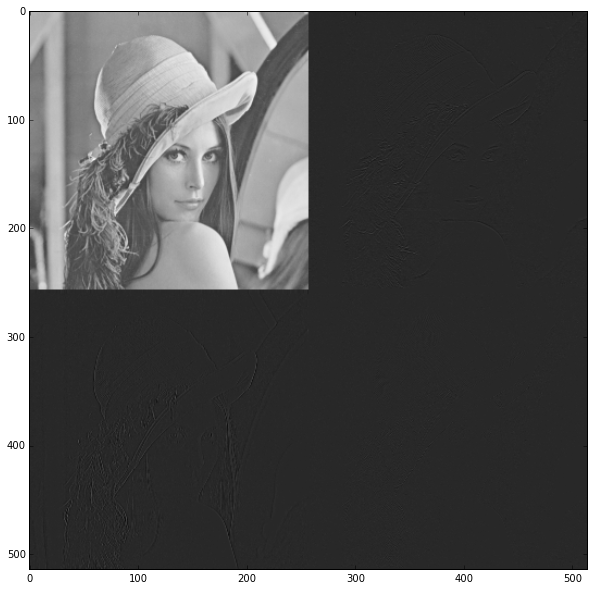

In [87]:
import matplotlib.pyplot as plt
import scipy.misc
lena = scipy.misc.lena()

from pywt import multilevel
coeffs = multilevel.dwt2(lena, 'db2')
cA, (cH, cV, cD) = coeffs
#plt.imshow(cD)
n = lena.shape[0]
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(np.bmat([[cA, cH], [cV, cD]]))
#ax.imshow(cD)

## Back to compressed sensing

Thus, given $Ax = y,$

we first find the representation $x \approx W s,$

where $W$ is known, and try to solve for

$$A W s \approx y,$$

with the assumption that $s$ is sparse.

But how to find those **sparsest solutions?.**

## Finding sparse solutions of linear systems

There are several methods for finding sparse solutions of overdetermined linear systems.

For more details, you can read [the review](http://www.researchgate.net/profile/Alfred_Bruckstein/publication/220116567_From_Sparse_Solutions_of_Systems_of_Equations_to_Sparse_Modeling_of_Signals_and_Images/links/0912f5088e5bca1f3f000000.pdf).

which we basically follow.

## Questions and problem

$$Ax = b.$$

Q1: When can uniqueness of the sparsest solution be claimed?  
Q2: Can a candidate solution be tested to verify its (global) optimality?  
Q3: Can the solution be reliably and efficiently found in practice? and finally,  
Q4: What performance guarantees can be given for various approximate and practical solvers?  

## Uniqueness

We need the new notion of the **rank** of the matrix.

The rank of the matrix is the maximal number of linear independent columns of the matrix.

The **spark** of a given matrix is the smallest number of linearly dependent columns of the matrix.

From the definition, if we have

$$Ax = 0,$$

then $\Vert x \Vert_0 \geq spark(A).$ 

## Theorem

If the system of linear equations $Ax = b$ has a solution $x$ obeying $\Vert x \Vert_0 < spark(A)/2$, then this solution is the sparsest possible.

**Proof:** If there is another solution with less zeros, then $\Vert x \Vert_0 + \Vert y \Vert_0 \geq \Vert x - y \Vert_0 \geq spark(A)$.  

Any alternative solution should have more than $spark(A)/2$ non-zeros. 

## How large spark can be?

The spark can not be larger than $n+1$. For a random matrix $A$, with probability $1$ we have $spark(A) = n + 1$. However, if $A$ has zero column, that it is a big problem.

## Uniqueness and mutual coherence

Computing spark is as difficult, as solving the original problem, thus we need to have computable quantities. 

The **mutual coherence** is the simplest choice. 

It is defined as

$$\mu(A) = \max_{1 \leq k, j \leq m} \frac{a^*_k a_j}{\Vert a_k \Vert_2 \Vert a_j \Vert_2}.$$

For a unitary matrix $\mu$ is zero, for a general matrix it is possible and we want to make it as small as possible.

For random orthogonal matrices $\mu \sim \sqrt{\frac{\log(nm)}{n}}$.

## Mutual coherence and spark

Mutual coherence is easy to compute and provides a lower bound for spark:

$$spark(A) \geq 1 + \frac{1}{\mu(A)}.$$

## Proof

First, scale the columns of $A$ to make the $1$ in the Euclidean norm.

The entries of the Gram matrix $G = A^* A$ satisfy 

$$
    G_{kk} = 1, \quad |G_{kj}| \leq \mu.
$$

Now consider an arbitrary $p \times p$ minor of $G$. 

If this minor is diagonally dominant, then from the Gershgorin disk theorem then the submatrix of $G$ is positive definite and the columns are linearly independent. 

Condition $p < 1 + \frac{1}{\mu}$ guarantees the diagonal dominance of all $p \times p$ minor of the Gram matrix.

## Practical algorithms

Suppose spark(A) > 2 and the solution has only $1$ non-zero. 

Then we can do $m$ tests to recover the location.

For $k_0$ non-zeros, we will have to test $\mathcal{O}(m^{k_0})$ possible combinations.

**We can do greedy method:**

At each step, add just one index to the **active index set.**

If we know the index set, we can compute the coefficients by solving linear least squares.

The main question is which index to add.

## Orthogonal matching pursuit

**Initialization:** Set $x_0 = 0$, compute initial residual $r_0 = b - Ax_0 = b.$ Set initial support to $S = \{\}.$.

**Iteration:** Compute the errors $\varepsilon(j) = \min_{z_j} \Vert a_j z_j - r_j \Vert_2$ for all $j$ using the optimal choice.  
               **Update support:** Find  a minimizer $j_0$ of $\epsilon(j)$, and increase support.  
               **Update provisional solution:** Find $x_k$ that minimizes $\Vert A x - b \Vert_2$ subject to support.  
               **Update the residual:** $r_k = b - A x_k$.

## Convex relaxation techniques

If we replace 0-norm by its closest convex "friend" $L1$-norm, we get the **Basis pursuit** problem:

$$\min_x \Vert W x \Vert_1, \mbox{subject to } b = Ax,$$

where $W$ is a **diagonal scaling matrix.**

(since the 0-norm is insensitive to the norm of the columns, but $1$-norm is sensitive, a natural choice is $w_{ii} = \Vert a_i \Vert.$

We can solve it using modern LP (linear programming) solvers (interior point, simplex, ...)

## Does greedy work?

**Theorem**

For a system $Ax = b$ if the solution $x$ satisfies  

$$
    \Vert x \Vert_0 < \frac{1}{2}\left(1 + \frac{1}{\mu(A)}\right) 
$$

The OGA run with threshold $\epsilon_0 = 0$ is guaranteed to find it exactly.

Let us try to do it on whiteboard.

## Does Basis Pursuit work?

**Theorem**

For a system $Ax = b$ if the solution $x$ satisfies  

$$
    \Vert x \Vert_0 < \frac{1}{2}\left(1 + \frac{1}{\mu(A)}\right) 
$$

then there exists a unique solution of BP problem which is the unique solution of the sparse problem.

## Stability estimate

If the right-hand side is known up to some error $\delta$, then stability estimates can be also proven.

## Large-scale case

How to solve the problems for the large-scale case? 

First, we formulate our problem using Lagrange multipliers:

$$\min_x \lambda \Vert x \Vert_1 + \frac{1}{2} \Vert b - A x \Vert^2_2$$

What if $A$ is large and structured?

There are many methods (iterative shrinkage, Bregman iteration, projection method).

## Bregman iteration

Let us discuss one approach. First we introduce a new variable $y = x$ 

$$\min_{x, y, s} \lambda \Vert y \Vert_1 + \frac{1}{2} \Vert A x - b \Vert^2_2 + \langle x - y, s \rangle + \mu \Vert x - y \Vert^2.$$

Now we can do **alternating minimization:**

The most important point, is that minimization over $y$ is reduced to the separate minimization of function

$$\min_{y_i} \lambda |y|_i + (x_i - y_i) s_i + \mu (x_i - y_i)^2,$$

or equivalenly, minimization of


$$\min_{y_i} \lambda |y_i| + \mu(y_i - z_i)^2.$$

The solution is given by the **soft thresholding function:**

$$y_i = shrink\left(z_i, \frac{\lambda}{\mu}\right),$$

and soft thresholding is defined as

$$
   shrink(x, \delta)  = \begin{cases} 0, \quad &|x| < \delta  \\
   x - \delta, \quad &|x| \geq \delta
   \end{cases}
$$

## Bregman iteration (cont)

$$\min_{x, y, s} \lambda \Vert y \Vert_1 + \frac{1}{2} \Vert A x - b \Vert^2_2 + \langle x - y, s \rangle + \mu \Vert x - y \Vert^2.$$

Summary:

1. Least squares update for $x$
2. Shrinkage update for $y$
3. Gradient update for $s$.

## Quest for optimal basis

Ok, if we know that if the solution is sparse, we are able to recover it.

We also know, that wavelet basis gives a sparse representation. 

But this is a **particular basis** that is not adapted to the particular application.

The next step is to adapt the basis itself.

## Problem setting

Suppose we have a **database** of vectors $a_1, \ldots, a_N$. This can be, for example, **blocks** of images from the database.

Then we want to find a **dictionary** $d_1, \ldots, d_M$, $M \ll N$ such that every $a_k$ can be represented as a **sparse linear combination** of the dictionary vectors:

$$a_k = D c_k, $$

and $c_k$ is sparse.

The idea (called **K-SVD**) is to formulate the loss using $L_1$ - norm and then iteratively update the dictionary and coefficients. 

If you update only one atom from the dictionary, it is possible to write the optimization problem in terms of rank-$1$ approximation of the auxiliary matrix.

## Summary

- Many more topics & applications not covered 
- $L_1$ norm penalizes sparsity, so it is an excellent prior, if the right basis is found (K-SVD can be used)
- OMP & BP methods are the methods of choice for small-scale, 
- Bregman iteration (and its siblings like linearized Bregman) are the most efficient for Large-Scale Problems.


##  Next lecture

On the next lecture we will talk about **multilinear algebra** and **tensors.**


# Questions?

In [66]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()